## Neural importance sampling

In order to predict cross-sections from theoretical models, it is necessary to integrate differential cross sections. This is usually achieved via Monte Carlo integration. The precision of this method is proportional to the variance of the integrand and the number of function evaluations. In order to save computational ressources, it is necessary to reduce the variance as far as possible. This is done via importance sampling: changing the sampling density such that more important regions of the integrand are tested more often is equal to reducing the variance. Neural importance sampling tries to learn the integrand and sample proportional to its absolute value.

In a first step, you should have installed Python, Matplotlib, PyTorch (`pip install torch`), vegas (`pip install vegas`) and numpy. Now, you need to install the neural importance sampling package:
`pip install https://github.com/NGoetz/NF.git#egg=nisrep`


Let's start by importing necessary packages and defining a simple 2D function to learn.


In [2]:
import torch
from nisrep.normalizing_flows.manager import *

from nisrep.PhaseSpace.flat_phase_space_generator import *
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import numpy as np
import vegas
torch.set_default_dtype(torch.double)
def create_fun(gn, gw):  #A function creating multi-peak gaussians
    
    if(gn==1):
        def f(x):
                return torch.exp(-torch.sum((x-0.5)**2/(gw**2),-1))
        return f
    
    if(gn==2):
        def f(x):
                return torch.exp(-torch.sum((x-0.25)**2/(gw**2),-1))+torch.exp(-torch.sum((x-0.75)**2/(gw**2),-1))
        return f
    
    if(gn==4):
        def f(x):
            shift=torch.ones_like(x)*0.25
            shift1=shift.clone()*3
            lim=int((shift.shape[1]/2))
            shift2=torch.cat((shift[:,:lim],shift1[:,lim:]),-1)
            shift3=torch.cat((shift1[:,:lim],shift[:,lim:]),-1)
            return torch.exp(-torch.sum((x-shift)**2/(gw**2),-1))+torch.exp(-torch.sum((x-shift1)**2/(gw**2),-1))+torch.exp(-torch.sum((x-shift2)**2/(gw**2),-1))+torch.exp(-torch.sum((x-shift3)**2/(gw**2),-1))
        return f
    
    if(gn==8):
        def f(x):
            shift=torch.ones_like(x)*0.25#000
            shift1=shift.clone()*3#111
            lim=int((shift.shape[1]/3))
            shift2=torch.cat((shift[:,:lim],shift1[:,lim:2*lim],shift[:,2*lim:]),-1) #010
            shift3=torch.cat((shift1[:,:lim],shift[:,lim:]),-1)#100
            shift4=torch.cat((shift1[:,:lim],shift1[:,lim:2*lim],shift[:,2*lim:]),-1) #110
            shift5=torch.cat((shift[:,:2*lim],shift1[:,2*lim:]),-1) #001
            shift6=torch.cat((shift1[:,:lim],shift[:,lim:2*lim],shift1[:,2*lim:]),-1) #101
            shift7=torch.cat((shift[:,:lim],shift1[:,lim:]),-1) #011
            return torch.exp(-torch.sum((x-shift)**2/(gw**2),-1))+torch.exp(-torch.sum((x-shift1)**2/(gw**2),-1))+torch.exp(-torch.sum((x-shift2)**2/(gw**2),-1))+torch.exp(-torch.sum((x-shift3)**2/(gw**2),-1))+torch.exp(-torch.sum((x-shift4)**2/(gw**2),-1))+torch.exp(-torch.sum((x-shift5)**2/(gw**2),-1))+torch.exp(-torch.sum((x-shift6)**2/(gw**2),-1))+torch.exp(-torch.sum((x-shift7)**2/(gw**2),-1))
        return f
def create_funv(gn, gw):
    
    if(gn==1):
        def f(x):
                return np.exp(-np.sum((x-0.5)**2/(gw**2),-1))
        return f # peak at [0.5,...,0.5]
    
    if(gn==2):
        def f(x):
                return np.exp(-np.sum((x-0.25)**2/(gw**2),-1))+np.exp(-np.sum((x-0.75)**2/(gw**2),-1))
        return f  #peak at [0.25,...,0.25] and [0.75,...,0.75]
    
   
    if(gn==4):
        
        def f(x):
            shift=np.ones_like(x)*0.25
            shift1=shift.copy()*3
            lim=int((shift.shape[0]/2))
            shift2=np.concatenate((shift[:lim],shift1[lim:]),-1)
            shift3=np.concatenate((shift1[:lim],shift[lim:]),-1)
            return np.exp(-np.sum((x-shift)**2/(gw**2),-1))+np.exp(-np.sum((x-shift1)**2/(gw**2),-1))+np.exp(-np.sum((x-shift2)**2/(gw**2),-1))+np.exp(-np.sum((x-shift3)**2/(gw**2),-1))
        return f #peak at [0.25,...,0.25], [0.75,...,0.75],[0.25,...,0.75], [0.25,...,0.75]
                #in dim2, there would be in the [0,1] plane only two peaks, as two are identical
                # other than gn=2, the [1,2] plane has 4 peaks
              
    
    if(gn==8):
        
        def f(x):
            shift=np.ones_like(x)*0.25#000
            shift1=shift.copy()*3#111
            lim=int(shift.shape[0]/3)
            shift2=np.concatenate((shift[:lim],shift1[lim:2*lim],shift[2*lim:]),0) #010
            shift3=np.concatenate((shift1[:lim],shift[lim:]),0)#100
            shift4=np.concatenate((shift1[:lim],shift1[lim:2*lim],shift[2*lim:]),0) #110
            shift5=np.concatenate((shift[:2*lim],shift1[2*lim:]),0) #001
            shift6=np.concatenate((shift1[:lim],shift[lim:2*lim],shift1[2*lim:]),0) #101
            shift7=np.concatenate((shift[:lim],shift1[lim:]),0) #011
            return np.exp(-np.sum((x-shift)**2/(gw**2),-1))+np.exp(-np.sum((x-shift1)**2/(gw**2),-1))+np.exp(-np.sum((x-shift2)**2/(gw**2),-1))+np.exp(-np.sum((x-shift3)**2/(gw**2),-1))+ np.exp(-np.sum((x-shift4)**2/(gw**2),-1))+np.exp(-np.sum((x-shift5)**2/(gw**2),-1))+np.exp(-np.sum((x-shift6)**2/(gw**2),-1))+np.exp(-np.sum((x-shift7)**2/(gw**2),-1))
f=create_fun(2,0.25)
fv=create_funv(2,0.25)

Now, let's take a look at our test case:

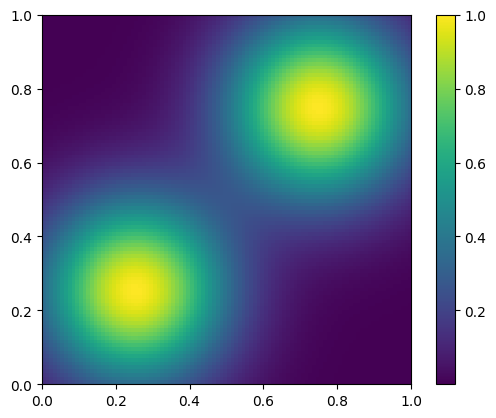

VARIANCE:
0.07944369944251192


In [3]:
xs = np.linspace(-0,1,100)
ys = np.linspace(1,0,100) 
Xs,Ys = np.meshgrid(xs,ys)
points=np.array(list(zip(Xs.reshape(100*100),Ys.reshape(100*100)))).astype(np.float32)
t=torch.tensor(points, dtype=torch.double)


plt.imshow(f(t).reshape(100,100).detach(), extent=[0,1,0,1])

plt.colorbar()
plt.show()
print("VARIANCE:")
var_old=torch.var(f(t))
print(var_old.numpy())

Normally, we would integrate with a uniform sampling distribution.

(0.0, 1.0)

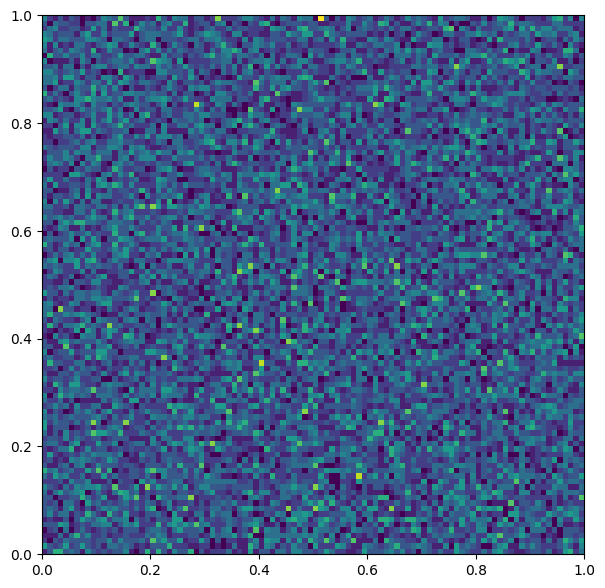

In [4]:
n_flow=2
w = torch.empty((30000,n_flow)) 
torch.nn.init.uniform_(w,0,1)

fig = plt.figure(figsize=(7, 7))
a3=fig.add_subplot(111)

plt.hist2d(w[:,0].numpy(),w[:,1].numpy(),bins=100)
axes = plt.gca()
axes.set_xlim([-0,1]) 
axes.set_ylim([-0,1])


Using this sampling distribution, we will have to work with a variance of 0.08, resulting in an standard error of 0.28. Now imagine we need the integral with an precision (standard error) of 1e-3. This would mean that we would have to use 80000 integration points, as the error of the integral falls with the square root of the evaluation points. How about we train instead a neural network such that it learns a transformation of the uniform distribution such that the variance is reduced? 

First we define our neural importance sampling manager in 2 dimensions with piecewise-quadratic coupling transforms:


In [5]:
NF =  PWQuadManager(n_flow=2)

Now let's define how many dimensions we want to transform, how the neural network should look and how many bins we want to use.

In [6]:
NF.create_model(n_cells=2, n_bins=10, NN=[16,16,16])

We need a gradient descent optimizer. Let's use a PyTorch one.

In [7]:
optim = torch.optim.Adamax(NF._model.parameters(),lr=1.4E-02, weight_decay=1E-04) 

Note that this all are not necessarily the optimal values for the hyperparameters. This is just for demonstration. 

In [8]:
NF._train_variance_forward_seq(f,optim,True, "./logs/tmp/",20000,500,0,True, True,None,0,mini_batch_size=20000, preburn_time=0)

Loss: 0.000e+00 | Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

(0, 0)

VARIANCE:
0.010028857445514922


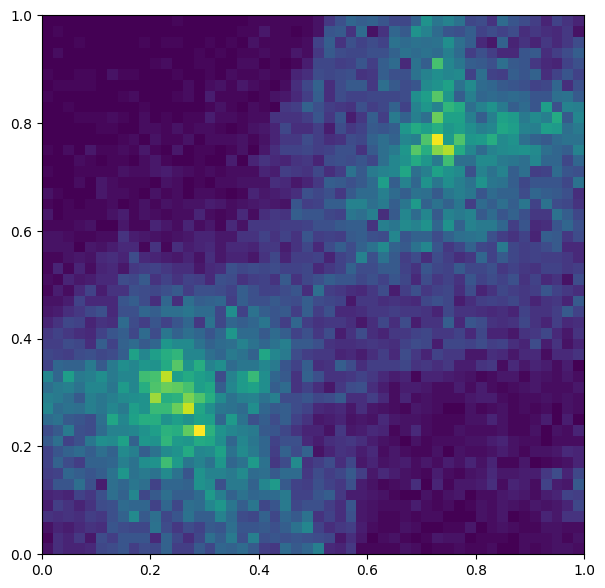

In [9]:
w = torch.empty((30000,n_flow)) 
torch.nn.init.uniform_(w,0,1)
Y=NF.format_input(w, dev=torch.device("cpu"))

XZ=NF.best_model(Y)


XX=XZ.data.numpy()

fig = plt.figure(figsize=(7, 7))
a3=fig.add_subplot(111)

plt.hist2d(XX[:,0],XX[:,1],bins=50)
axes = plt.gca()
axes.set_xlim([-0,1]) 
axes.set_ylim([-0,1])

print("VARIANCE:")
print(torch.var(f(XZ[:,:-1])*XZ[:,-1]).detach().numpy())

The variance is greatly reduced! Let's compare the accuarcy of the integral with a plain MC integration!

In [10]:
print("Result without training:")
res=0
res_err=torch.sqrt(var_old/(50*5000)).numpy()
w = torch.empty((2000,n_flow)) 

for i in range(50):
    torch.nn.init.uniform_(w,0,1)
    res+=torch.mean(f(w)).numpy()/50
print(str(res)+" +/- "+str(res_err))
print("Result with training:")
sig, sig_err=NF.integrate(f, 50,5000)
print(str(sig.numpy())+" +/- "+str(sig_err.numpy()))

Result without training:
0.33370259223296167 +/- 0.000563715174330129
Result with training:
0.3334588095742614 +/- 2.8401347228418352e-05


Now you surely noticed that training takes quite some time more. But on the one hand, it can be done much faster on a GPU, and on the other hand, many functions in High Energy Physics are much more difficult, turning the number of function evaluations needed in order to achieve a certain precision into the more important measure. 
Neural importance sampling is not the only way of importance sampling. Why is it superior? Let's look at what an important competitor, VEGAS, does:

In [11]:
integ = vegas.Integrator([[0, 1], [0, 1]])
result = integ(fv, nitn=50, neval=5000)
print("Result with VEGAS:")
print(str(result.mean)+" +/- "+str(result.sdev))

Result with VEGAS:
0.33336369368984553 +/- 4.442796419796554e-05


Why does a high-end tool for importance sampling give a worse result? VEGAS learns every axis independent and cannot deal with correlations:

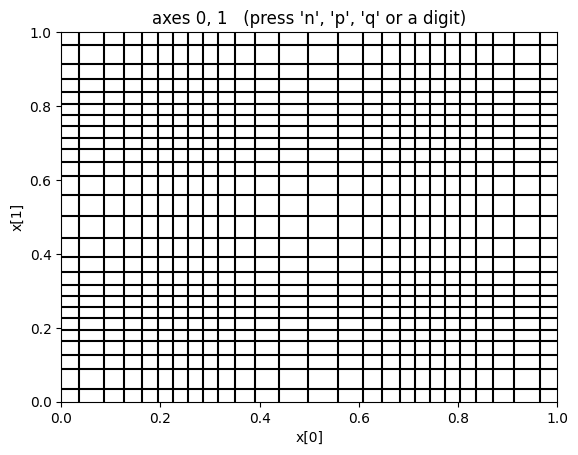

In [12]:
m = vegas.AdaptiveMap(integ.map)
m.show_grid(25,[[0,1]])

VEGAS sees four peaks instead of two, spoiling its efficiency. Neural importance sampling is not hampered by this problems.